In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 515 (delta 245), reused 479 (delta 231), pack-reused 0
Receiving objects: 100% (515/515), 29.39 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# Dealing with Few to No Labels

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter09_decision-tree.png?raw=1" id="decision-tree"/>

## Building a GitHub Issues Tagger

<img alt="issue-example" caption="A typical GitHub issue on the Transformers repository" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter09_issue-example-v2.png?raw=1" id="issue-example"/>

### Getting the Data

If you want to download the issues yourself, you can query the Issues endpoint by using the _Requests_ library, which is the standard way for making HTTP requests in Python. Here is a function to fetch the issues from the Transformers repository:

```
# NO NEED TO RUN:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000, rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page.
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"
    
    for page in tqdm(range(num_pages)):
        # Query with `state=all` to get both open and closed issues.
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period.
            print(f"Reached GitHub rate limit. Sleeping for one hour ...")
            time.sleep(60 * 60 + 1)
            
    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)
```

Now when you call `fetch_issues()`, it will download all the issues in batches to avoid exceeding GitHub's limit on the number of requests per hour. The results will be stored in an _github-issues-transformers.jsonl_ file, where each line is a JSON object that represents the issue.

### Preparing the Data

In [ ]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [ ]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [ ]:
df_issues["labels"].loc[2]

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

In [ ]:
df_issues["labels"] = df_issues["labels"].apply(lambda x: [meta['name'] for meta in x])
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [ ]:
df_issues["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


How `pd.Series.explode()` works:

In [ ]:
df = pd.DataFrame({'id': [100, 101], 'letters': [["a", "b"], ["b", "c"]]})
df

,id,letters
0,100,"[a, b]"
1,101,"[b, c]"


In [ ]:
df['letters'].explode()

0    a
0    b
1    b
1    c
Name: letters, dtype: object

In [ ]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top 8 labels:
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [ ]:
label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

**Note:** If a row contains a label that isn't one of the above 9 labels, then it will be removed from the row.

In [ ]:
df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [ ]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [ ]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x) > 0)
mask

0       False
1       False
2       False
3       False
4       False
        ...  
9925    False
9926    False
9927    False
9928    False
9929    False
Name: labels, Length: 9930, dtype: bool

In [ ]:
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


**Note:** The vast majority of rows are unlabeled!

In [ ]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n") # Print these three columns of example `26`; limit to `500` characters.

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels: ['new model']



In [ ]:
df_issues["text"] = df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1)

In [ ]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before - len(df_issues)) / len_before:.2%} duplicates.")

Removed 1.88% duplicates.


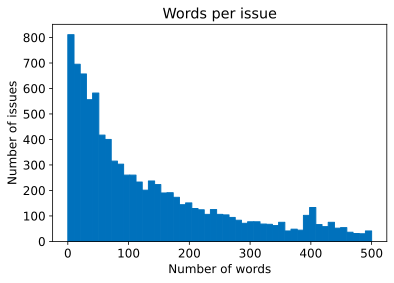

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0")
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

**Note:** `bins=np.linspace(0, 500, 50)` sets the upper bound of the x-axis to `500`. This is because there are some outliers which will ruin the plot otherwise:

In [ ]:
df_issues["text"].str.split().apply(len).describe()

count     9743.000000
mean       184.437750
std        475.171853
min          1.000000
25%         35.000000
50%         97.000000
75%        230.000000
max      26944.000000
Name: text, dtype: float64

In [ ]:
np.linspace(0, 500, 50)

array([  0.        ,  10.20408163,  20.40816327,  30.6122449 ,
        40.81632653,  51.02040816,  61.2244898 ,  71.42857143,
        81.63265306,  91.83673469, 102.04081633, 112.24489796,
       122.44897959, 132.65306122, 142.85714286, 153.06122449,
       163.26530612, 173.46938776, 183.67346939, 193.87755102,
       204.08163265, 214.28571429, 224.48979592, 234.69387755,
       244.89795918, 255.10204082, 265.30612245, 275.51020408,
       285.71428571, 295.91836735, 306.12244898, 316.32653061,
       326.53061224, 336.73469388, 346.93877551, 357.14285714,
       367.34693878, 377.55102041, 387.75510204, 397.95918367,
       408.16326531, 418.36734694, 428.57142857, 438.7755102 ,
       448.97959184, 459.18367347, 469.3877551 , 479.59183673,
       489.79591837, 500.        ])

In [ ]:
np.linspace(0, 500, 50).shape

(50,)

### Creating Training Sets

In [ ]:
# Reminder:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
# A batch of two rows:
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [ ]:
mlb.classes_

array(['documentation', 'examples', 'model training', 'new model',
       'pipeline', 'pytorch', 'tensorflow or tf', 'tokenization', 'usage'],
      dtype=object)

Since `iterative_train_test_split()` expects a two-dimensional feature matrix, we need to add a dimension to the possible indices before making the split.

In [ ]:
np.arange(len(df_issues))

array([   0,    1,    2, ..., 9740, 9741, 9742])

In [ ]:
ind = np.expand_dims(np.arange(len(df_issues)), axis=1)
ind

array([[   0],
       [   1],
       [   2],
       ...,
       [9740],
       [9741],
       [9742]])

In [ ]:
labels = mlb.transform(df_issues["labels"])
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

In [ ]:
help(iterative_train_test_split)

Help on function iterative_train_test_split in module skmultilearn.model_selection.iterative_stratification:

iterative_train_test_split(X, y, test_size)
    Iteratively stratified train/test split
    
    Parameters
    ----------
    test_size : float, [0,1]
        the proportion of the dataset to include in the test split, the rest will be put in the train set
    
    Returns
    -------
    X_train, y_train, X_test, y_test
        stratified division into train/test split



In [ ]:
np.random.seed(0)
ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size=0.5)

In [ ]:
ind_train

array([[  26],
       [ 107],
       [ 148],
       ...,
       [9736],
       [9740],
       [9742]])

In [ ]:
ind_train.shape

(4872, 1)

In [ ]:
ind_test

array([[   0],
       [   1],
       [   2],
       ...,
       [9738],
       [9739],
       [9741]])

In [ ]:
ind_test.shape

(4871, 1)

Let's wrap the above steps into a function.

In [ ]:
def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [ ]:
df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy(deep=True)
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)
df_train.shape, df_valid.shape, df_test.shape, df_unsup.shape

((223, 2), (106, 2), (111, 2), (9303, 2))

In [ ]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

In [ ]:
ds["train"][0]

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

**Note:** The `'labels'` column hasn't been binarized in the `DatasetDict`. So far, `MultiLabelBinarizer` has just been used to generate the splits.

### Creating Training Slices

In [ ]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
all_indices[:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [ ]:
all_indices.shape

(223, 1)

Alt:

In [ ]:
all_indices = np.expand_dims(np.arange(len(ds["train"])), axis=1)
all_indices[:5]

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [ ]:
all_indices.shape

(223, 1)

In [ ]:
indices_pool = all_indices

You can think of `indices_pool` as being the remaining indices (in each iteration).

In [ ]:
# Reminder:
ds["train"][0]

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

In [ ]:
labels = mlb.transform(ds["train"]["labels"])
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

When creating training slices, we'll use `iterative_train_test_split()` to ensure that the labels are balanced in each training split (vis-a-vis the `"test"` split in `ds` which will be used for model evaluation).

In [ ]:
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

In [ ]:
# Reminder:
help(iterative_train_test_split)

Help on function iterative_train_test_split in module skmultilearn.model_selection.iterative_stratification:

iterative_train_test_split(X, y, test_size)
    Iteratively stratified train/test split
    
    Parameters
    ----------
    test_size : float, [0,1]
        the proportion of the dataset to include in the test split, the rest will be put in the train set
    
    Returns
    -------
    X_train, y_train, X_test, y_test
        stratified division into train/test split



In [ ]:
# Don't worry too much about this code:
for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size:
    print(f"indices_pool.shape: {indices_pool.shape}")
    print(f"labels.shape: {labels.shape}")
    print(f"test_size: {(k - last_k) / len(labels)}")
    indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool, labels, (k - last_k) / len(labels))
    print(f"new_slice.shape: {new_slice.shape}")
    last_k = k
    if i == 0:
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice), axis=0))
    print(f"Shape of appended training slice: {train_slices[-1].shape}")
    print("---")

# Add full dataset as last slice:
train_slices.append(all_indices)
train_samples.append(len(ds["train"]))
print(f"Shape of appended training slice: {train_slices[-1].shape}")
print("---")

indices_pool.shape: (223, 1)
labels.shape: (223, 9)
test_size: 0.03587443946188341
new_slice.shape: (10, 1)
Shape of appended training slice: (10, 1)
---
indices_pool.shape: (213, 1)
labels.shape: (213, 9)
test_size: 0.03755868544600939
new_slice.shape: (9, 1)
Shape of appended training slice: (19, 1)
---
indices_pool.shape: (204, 1)
labels.shape: (204, 9)
test_size: 0.0784313725490196
new_slice.shape: (17, 1)
Shape of appended training slice: (36, 1)
---
indices_pool.shape: (187, 1)
labels.shape: (187, 9)
test_size: 0.1711229946524064
new_slice.shape: (32, 1)
Shape of appended training slice: (68, 1)
---
indices_pool.shape: (155, 1)
labels.shape: (155, 9)
test_size: 0.4129032258064516
new_slice.shape: (66, 1)
Shape of appended training slice: (134, 1)
---
Shape of appended training slice: (223, 1)
---


A couple of observations:

1. The `X_test` variable (not `X_train`) returned by `iterative_train_test_split()` is actually `new_slice`.
2. At each iteration, the concatenation of `new_slice` and the previous slice is being appended to `train_slices`.

Let's flatten each training slice to a rank 1 array.

In [ ]:
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]
for train_slice in train_slices:
    print(train_slice.shape)

(10,)
(19,)
(36,)
(68,)
(134,)
(223,)


In [ ]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


## Implementing a Naive Bayesline

In [ ]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)
ds

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label_ids', 'labels', 'text'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['label_ids', 'labels', 'text'],
        num_rows: 106
    })
    test: Dataset({
        features: ['label_ids', 'labels', 'text'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['label_ids', 'labels', 'text'],
        num_rows: 9303
    })
})

In [ ]:
ds['train'][0]

{'label_ids': [0, 0, 0, 1, 0, 0, 0, 0, 0],
 'labels': ['new model'],
 'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally use

To understand the difference between macro-averaged F1-score & micro-averaged F1-score, study this excellent article: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

In [ ]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

From the <a href="https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes" target="_blank">documentation</a> of `MultinomialNB`:

> `MultinomialNB` implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

From the <a href="http://scikit.ml/api/skmultilearn.problem_transform.br.html" target="_blank">documentation</a> of `BinaryRelevance`:

> Performs classification per label.

> Transforms a multi-label classification problem with L labels into L single-label separate binary classification problems using the same base classifier provided in the constructor. The prediction output is the union of all per label classifiers.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Reminder:
[len(x) for x in train_slices]

[10, 19, 36, 68, 134, 223]

First, let's understand the process with a single training slice.

In [ ]:
train_slice = train_slices[0]
train_slice.shape

(10,)

In [ ]:
train_slice

array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92])

In [ ]:
ds_train_sample = ds["train"].select(train_slice)
ds_train_sample

Dataset({
    features: ['label_ids', 'labels', 'text'],
    num_rows: 10
})

In [ ]:
y_train = np.array(ds_train_sample["label_ids"])
y_train.shape

(10, 9)

In [ ]:
y_train

array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
y_test = np.array(ds["test"]["label_ids"])
y_test.shape

(111, 9)

**Note:** The `"test"` split will be used for model evaluation, and the `"valid"` split for hyperparameter tuning (e.g., in the ***Working with No Labeled Data*** section).

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
type(X_train_counts)

scipy.sparse.csr.csr_matrix

In [ ]:
X_train_counts.shape

(10, 887)

There are 887 words.

In [ ]:
pd.DataFrame.sparse.from_spmatrix(X_train_counts)

,0,1,2,3,4,5,6,7,8,9,...,877,878,879,880,881,882,883,884,885,886
0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,1,1,4,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,1,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,5,3,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,2
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2,0


In [ ]:
X_test_counts = count_vect.transform(ds["test"]["text"])
X_test_counts.shape

(111, 887)

In [ ]:
classifier = BinaryRelevance(classifier=MultinomialNB())
classifier.fit(X_train_counts, y_train)
y_pred_test = classifier.predict(X_test_counts)
type(y_pred_test)

scipy.sparse.csc.csc_matrix

**Note:**

1. `X_train_counts` is a sparse matrix, and `y_train` is a standard NumPy array. `y_pred_test` is a sparse matrix.
2. We're using the default probability threshold of `0.5` in the `classifier.predict()` step.

In [ ]:
y_pred_test.shape

(111, 9)

In [ ]:
pd.DataFrame.sparse.from_spmatrix(y_pred_test)

,0,1,2,3,4,5,6,7,8
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0
108,0,0,0,0,1,0,0,0,0
109,0,0,0,0,0,0,0,0,0


In [ ]:
# Reminder:
mlb.classes_

array(['documentation', 'examples', 'model training', 'new model',
       'pipeline', 'pytorch', 'tensorflow or tf', 'tokenization', 'usage'],
      dtype=object)

From the documentation of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html" target="_blank">classification_report()</a>:

> `zero_division`: `"warn"`, `0` or `1`, default=`"warn"`

> Sets the value to return when there is a zero division. If set to `"warn"`, this acts as `0`, but warnings are also raised.

In [ ]:
clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)
clf_report

{'documentation': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 7},
 'examples': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6},
 'model training': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 16},
 'new model': {'precision': 1.0,
  'recall': 0.7083333333333334,
  'f1-score': 0.8292682926829268,
  'support': 24},
 'pipeline': {'precision': 0.5,
  'recall': 0.18181818181818182,
  'f1-score': 0.26666666666666666,
  'support': 11},
 'pytorch': {'precision': 0.6, 'recall': 0.3, 'f1-score': 0.4, 'support': 10},
 'tensorflow or tf': {'precision': 0.4,
  'recall': 0.18181818181818182,
  'f1-score': 0.25000000000000006,
  'support': 11},
 'tokenization': {'precision': 0.5,
  'recall': 0.2692307692307692,
  'f1-score': 0.35000000000000003,
  'support': 26},
 'usage': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12},
 'micro avg': {'precision': 0.6326530612244898,
  'recall': 0.25203252032520324,
  'f1-score': 0.3604

In [ ]:
clf_report["macro avg"]["f1-score"], clf_report["micro avg"]["f1-score"]

(0.23288166214995487, 0.3604651162790698)

In [ ]:
macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
macro_scores

defaultdict(list, {'Naive Bayes': [0.23288166214995487]})

In [ ]:
micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])
micro_scores

defaultdict(list, {'Naive Bayes': [0.3604651162790698]})

Let's now write out the full loop.

In [ ]:
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

for train_slice in train_slices:
    # Get training slice data and test data:
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts:
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model:
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate:
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)
    # Store metrics:
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [ ]:
macro_scores

defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086]})

In [ ]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347]})

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

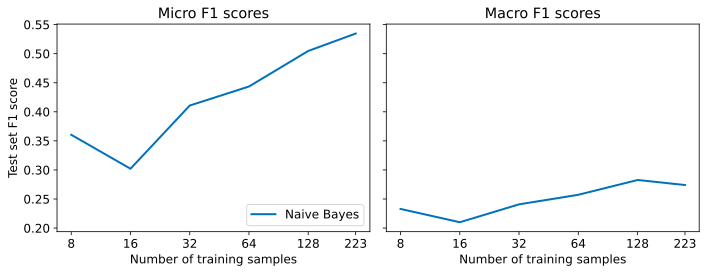

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

## Working with No Labeled Data

**Note:** Switch to a premium GPU, high RAM runtime.

In [ ]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
output

[{'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about animals.',
  'score': 0.10329320281744003,
  'token': 4176,
  'token_str': 'animals'},
 {'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about lions.',
  'score': 0.0655355453491211,
  'token': 7212,
  'token_str': 'lions'},
 {'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about birds.',
  'score': 0.0245838463306427,
  'token': 5055,
  'token_str': 'birds'},
 {'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about love.',
  'score': 0.0146418372169137,
  'token': 2293,
  'token_str': 'love'},
 {'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about hunting.',
  'score': 0.012745711021125317,
  'token':

In [ ]:
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:  0.103%
Token lions:    0.066%
Token birds:    0.025%
Token love:     0.015%
Token hunting:  0.013%


In [ ]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
output

[{'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about animals.',
  'score': 0.10329320281744003,
  'token': 4176,
  'token_str': 'animals'},
 {'sequence': 'the main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo. the movie is about cars.',
  'score': 0.0007419332396239042,
  'token': 3765,
  'token_str': 'cars'}]

In [ ]:
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:  0.103%
Token cars:     0.001%


In [ ]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles. "

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:     0.139%
Token animals:  0.006%


In [ ]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
sample = ds["train"][0]
sample

{'label_ids': [0, 0, 0, 1, 0, 0, 0, 0, 0],
 'labels': ['new model'],
 'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally use

In [ ]:
print(f"Labels: {sample['labels']}")

Labels: ['new model']


In [ ]:
# Reminder:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [ ]:
output = pipe(sample["text"], all_labels, multi_label=True)
output

{'sequence': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained inp

In [ ]:
# Just for comparison:
output_multiclass = pipe(sample["text"], all_labels, multi_label=False)
output_multiclass

{'sequence': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained inp

**Note:** In the multiclass case, softmax is being applied to the logits, whereas in the multilabel case, sigmoid is being applied.

In [ ]:
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [ ]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

Let's test it out.

In [ ]:
zero_shot_pipeline(sample)

{'label_ids': [0, 0, 0, 1, 0, 0, 0, 0, 0],
 'labels': ['new model'],
 'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally use

Let's now map it to the entire validation split.

In [ ]:
ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# Reminder:
# A batch of two rows:
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [ ]:
# So a batch of just one row:
mlb.transform([["tokenization", "new model"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0]])

In [ ]:
np.squeeze(mlb.transform([["tokenization", "new model"]]))

array([0, 0, 0, 1, 0, 0, 0, 1, 0])

In [ ]:
list(np.squeeze(mlb.transform([["tokenization", "new model"]])))

[0, 0, 0, 1, 0, 0, 0, 1, 0]

In [ ]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

**Note:** The predicted labels are appended to `preds` in decreasing order of probability. But `mlb.transform()` puts the ones in the right column indices (based on `mlb.classes_`).

Let's test out the function.

In [ ]:
ds_zero_shot[0]

{'label_ids': [0, 0, 0, 1, 0, 0, 0, 0, 0],
 'labels': ['new model'],
 'text': 'Implementing efficient self attention in T5\n\n# 🌟 New model addition\r\n\r\nMy teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and Nystromformer\r\n\r\n## Model description\r\n\r\nThese new methods serve as approximations of regular attention, but reduce complexity from quadratic in the inputs to linear.  We would like to add a parameter to T5 where users can specify an efficient attention method to use instead of regular attention.  Ideally, this would be implemented across all models, but the models tend to have varying implementations of attention, rendering this generalization fairly tedious.\r\n\r\n## Open source status\r\n\r\n* [x] the model implementation is available: repos are https://github.com/mlpen and https://github.com/lucidrains/performer-pytorch\r\n* [ ] the model weights are available: N/A\r\n* [x] who are the author

In [ ]:
try:
    get_preds(ds_zero_shot[0])
except ValueError as error:
    print(error)

Set either `threshold` or `topk`.


In [ ]:
get_preds(ds_zero_shot[0], threshold=0.5)

{'pred_label_ids': [1, 0, 0, 1, 0, 1, 0, 0, 0]}

In [ ]:
get_preds(ds_zero_shot[0], topk=2)

{'pred_label_ids': [0, 0, 0, 1, 0, 1, 0, 0, 0]}

In [ ]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

In [ ]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

**Note:** `fn_kwargs` is an alternative to using `functools.partial()`.

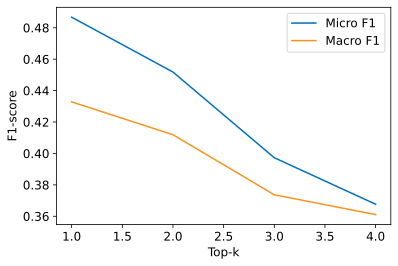

In [ ]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [ ]:
np.linspace(0.01, 1, 100)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [ ]:
np.linspace(0.01, 1, 100).shape

(100,)

In [ ]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

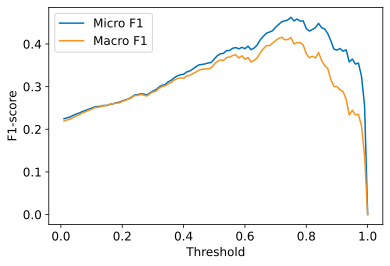

In [ ]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [ ]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f"Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.")
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f"Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.")

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (macro): 0.72 with F1-score 0.42.


**From the book:**

> "Since the top-1 method performs best, let’s use this to compare zero-shot classification against Naive Bayes on the test set:"

**Note:** How will the results change if we use a custom threshold for each class? This experiment is worth doing for both Naive Bayes and zero-shot classification.

In [ ]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices: # Note: We're not using `train_slice` anywhere.
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

  0%|          | 0/111 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/111 [00:00<?, ?ex/s]

In [ ]:
macro_scores

defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086],
             'Zero Shot': [0.39372541039207704,
              0.39372541039207704,
              0.39372541039207704,
              0.39372541039207704,
              0.39372541039207704,
              0.39372541039207704]})

In [ ]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero Shot': [0.4615384615384615,
              0.4615384615384615,
              0.4615384615384615,
              0.4615384615384615,
              0.4615384615384615,
              0.4615384615384615]})

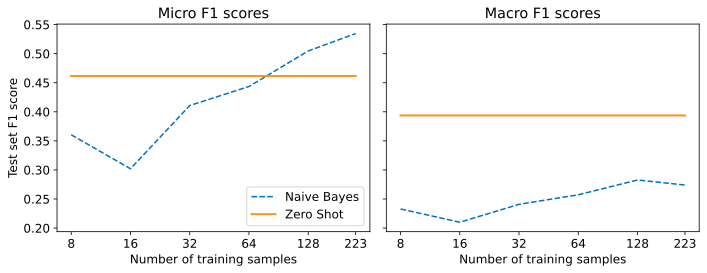

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

## Working with a Few Labels

### Data Augmentation

In [ ]:
from transformers import set_seed

In [ ]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}

From the WordNet <a href="https://wordnet.princeton.edu/" target="_blank">website</a>:

> "WordNet® is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept."

In [ ]:
augs["synonym_replace"] = naw.SynonymAug(aug_src="wordnet")
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(from_model_name="facebook/wmt19-en-de", to_model_name="facebook/wmt19-de-en")
augs

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

{'synonym_replace': <nlpaug.augmenter.word.synonym.SynonymAug at 0x7fd667653460>,
 'random_insert': <nlpaug.augmenter.word.context_word_embs.ContextualWordEmbsAug at 0x7fd6676533a0>,
 'random_swap': <nlpaug.augmenter.word.random.RandomWordAug at 0x7fd6676534f0>,
 'random_delete': <nlpaug.augmenter.word.random.RandomWordAug at 0x7fd667653400>,
 'bt_en_de': <nlpaug.augmenter.word.back_translation.BackTranslationAug at 0x7fd667653520>}

**Note:** `BackTranslationAug` is part of `nlpaug.augmenter.word`.

In [ ]:
for k, v in augs.items():
    print(f"Original text: {text}")
    print(f"Augmentation with '{k}': {v.augment(text)}")
    print("")

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
Augmentation with 'synonym_replace': Even if you defeat me Megatron, others
volition rise to defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
Augmentation with 'random_insert': even if you defeat me onto megatron, others
will rise to defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
Augmentation with 'random_swap': Even if you defeat Megatron me, will others to
rise your defeat tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
Augmentation with 'random_delete': Even defeat me Megatron, will to defeat your
tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
Augmentation with 'bt_en_de': Even if you defeat me, others will rise to defeat
your tyranny



**Note:** Every time you run the above cell, you'll get a slightly different set of augmentations.

In [ ]:
set_seed(3)
# aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="substitute")
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cuda", action="substitute")

**Note:** This is the second tool to perform synonym replacement. The first tool (shown above) is `naw.SynonymAug(aug_src="wordnet")`.

In [ ]:
text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: transformers'the most popular toys


In [ ]:
my_list = []
my_list.append(["Jeremy Howard"])
my_list.append(["Andrew Ng"])
my_list

[['Jeremy Howard'], ['Andrew Ng']]

In [ ]:
my_list = []
my_list.extend(["Jeremy Howard"])
my_list.extend(["Andrew Ng"])
my_list

['Jeremy Howard', 'Andrew Ng']

In [ ]:
my_list = []
my_list += ["Jeremy Howard"]
my_list += ["Andrew Ng"]
my_list

['Jeremy Howard', 'Andrew Ng']

In [ ]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)]
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

Let's test out the function.

In [ ]:
batch = ds["train"].shuffle(seed=0)[:2]
batch

{'label_ids': [[0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0]],
 'labels': [['model training'], ['tokenization']],
 'text': ['Help needed with interpretation of the MLP class\n\nHello,\r\n\r\nI am having some trouble understanding the MLP function used in the Hugging Face GPT-2, which is found [here](https://github.com/huggingface/transformers/blob/73028c5df0c28ca179fbe565482a9c2143787f61/src/transformers/modeling_gpt2.py#L204).\r\n\r\nQ1. For MLP, why are we setting the n_state to be equal to 3072, which is 4 * n_embd?\r\nQ2. Below is the definition for the MLP class:\r\n```python\r\nclass MLP(nn.Module):\r\n    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)\r\n        super().__init__()\r\n        nx = config.n_embd\r\n        self.c_fc = Conv1D(n_state, nx)\r\n        self.c_proj = Conv1D(nx, n_state)\r\n        self.act = gelu_new\r\n        self.dropout = nn.Dropout(config.resid_pdrop)\r\n```\r\nin the MLP definition above, what exactly do the 

In [ ]:
set_seed(3)
augment_text(batch)

{'text': ['Help needed with interpretation of the MLP class\n\nHello,\r\n\r\nI am having some trouble understanding the MLP function used in the Hugging Face GPT-2, which is found [here](https://github.com/huggingface/transformers/blob/73028c5df0c28ca179fbe565482a9c2143787f61/src/transformers/modeling_gpt2.py#L204).\r\n\r\nQ1. For MLP, why are we setting the n_state to be equal to 3072, which is 4 * n_embd?\r\nQ2. Below is the definition for the MLP class:\r\n```python\r\nclass MLP(nn.Module):\r\n    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)\r\n        super().__init__()\r\n        nx = config.n_embd\r\n        self.c_fc = Conv1D(n_state, nx)\r\n        self.c_proj = Conv1D(nx, n_state)\r\n        self.act = gelu_new\r\n        self.dropout = nn.Dropout(config.resid_pdrop)\r\n```\r\nin the MLP definition above, what exactly do the lines ``` Conv1D(n_state, nx)``` (the object ```self.c_fc```), and ``` Conv1D(nx, n_state)```   (the object ```self.c_proj```

In [ ]:
for train_slice in train_slices:
    # Get training slice and test data:
    ds_train_sample = ds["train"].select(train_slice)
    # The following doubles the size of the training slice. You can use `fn_kwargs` to control the size.
    ds_train_aug = ds_train_sample.map(augment_text, batched=True, remove_columns=ds_train_sample.column_names).shuffle(seed=42)
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts:
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model:
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate:
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)
    # Store metrics:
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:899: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


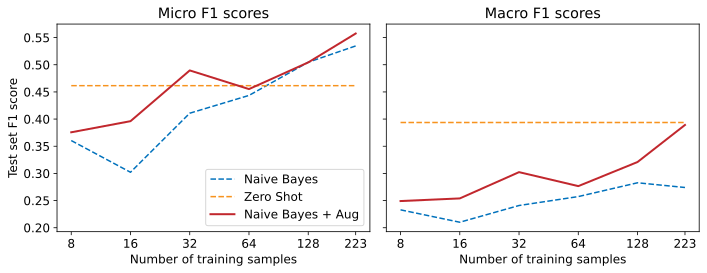

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

### Using Embeddings as a Lookup Table

<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter09_nearest-neighbours.png?raw=1" id="nearest-neighbours"/>

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [ ]:
# hide_output
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
# hide_output
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['embedding', 'label_ids', 'labels', 'text'],
    num_rows: 223
})

In [ ]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self
attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to
Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based
models with sign [...]
SCORE: 60.12
LABELS: ['new model']


In [ ]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

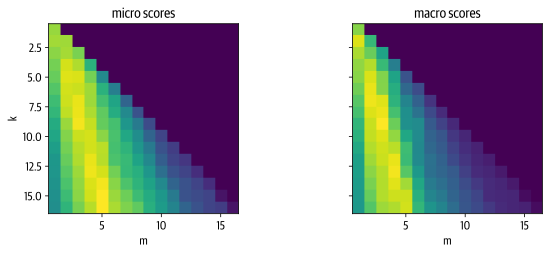

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [ ]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


In [ ]:
# hide_output
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

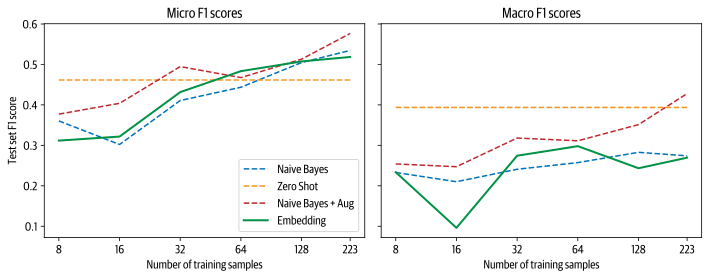

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

### Sidebar: Efficient Similarity Search with FAISS

<img alt="faiss-index" caption="The structure of a FAISS index: the gray points represent data points added to the index, the bold black points are the cluster centers found via k-means clustering, and the colored areas represent the regions belonging to a cluster center" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter09_faiss-index.png?raw=1" id="faiss-index"/>

### End sidebar

### Fine-Tuning a Vanilla Transformer

In [ ]:
#hide_output
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
#hide_output
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

  0%|          | 0/223 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/111 [00:00<?, ?ex/s]

  0%|          | 0/9303 [00:00<?, ?ex/s]

In [ ]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

In [ ]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [ ]:
#hide_output
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [ ]:
# hide_output
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

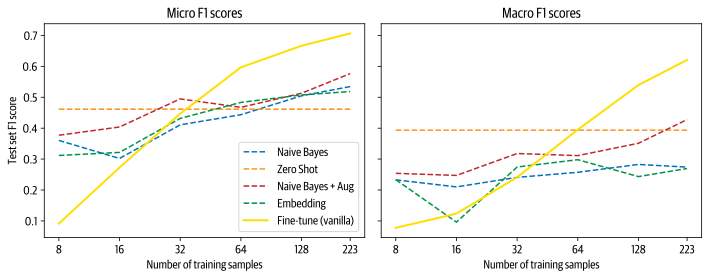

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

### In-Context and Few-Shot Learning with Prompts

In [ ]:
prompt = """\
Translate English to French:
thanks =>
"""

## Leveraging Unlabeled Data

### Fine-Tuning a Language Model

In [ ]:
#hide_output
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

In [ ]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

original_input_ids = inputs["input_ids"][0]
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [ ]:
data_collator.return_tensors = "pt"

In [ ]:
#hide_output
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

In [ ]:
# hide_output
trainer.push_to_hub("Training complete!")

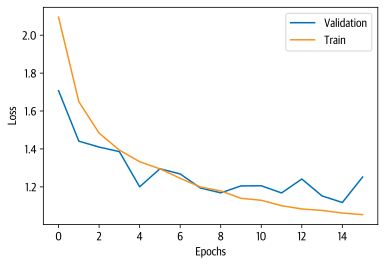

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Fine-Tuning a Classifier

In [ ]:
#hide_output
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

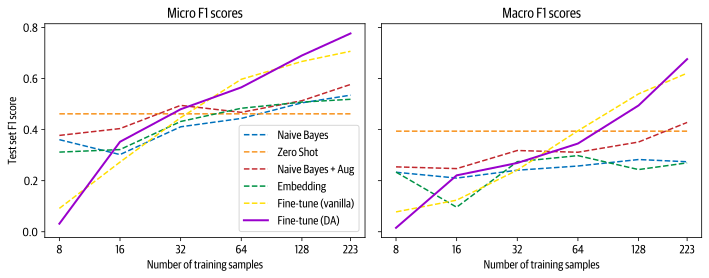

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

### Advanced Methods

#### Unsupervised data augmentation

<img alt="uda" width="600" caption="Training a model M with UDA (courtesy of Qizhe Xie)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter09_uda.png?raw=1" id="uda"/>    

#### Uncertainty-aware self-training

<img alt="ust" width="600" caption="The UST method consists of a teacher that generates pseudo-labels and a student that is subsequently trained on those labels; after the student is trained it becomes the teacher and the step is repeated (courtesy of Subhabrata Mukherjee)footnote:[S. Mukherjee and A.H. Awadallah, ["Uncertainty-Aware Self-Training for Few-Shot Text Classification"](https://arxiv.org/abs/2006.15315), (2020).]" src="images/chapter09_ust.png" id="ust"/>

## Conclusion